In [54]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile



In [55]:

# Ler o arquivo CSV
data_path = './DataSet/fer2013/fer2013.csv'
data = pd.read_csv(data_path)

# Obter a lista de pixels
pixels = data['pixels'].tolist()

In [56]:
def show_image_with_matplotlib(image):
    # Converter a imagem para o formato esperado por Matplotlib
    if len(image.shape) == 2:  # Imagem em escala de cinza
        plt.imshow(image, cmap='gray')
    else:  # Imagem colorida
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Desativar os eixos
    plt.show()


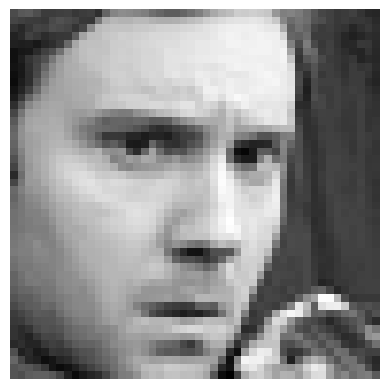

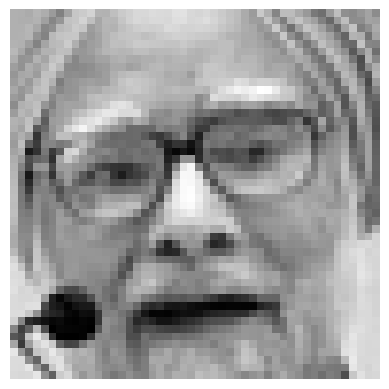

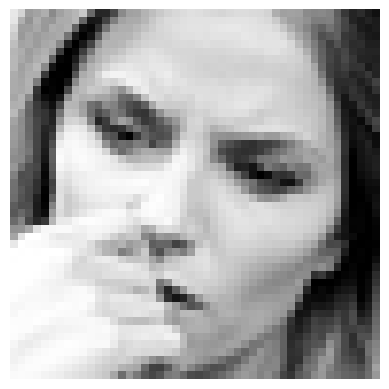

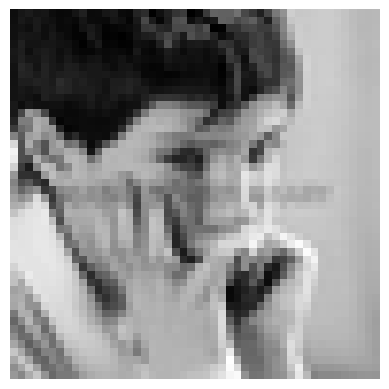

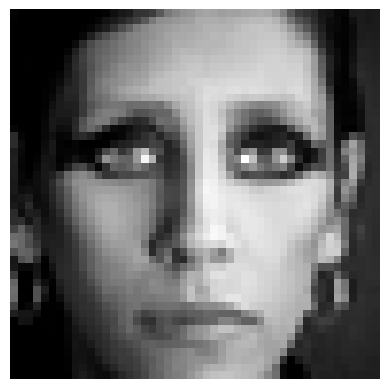

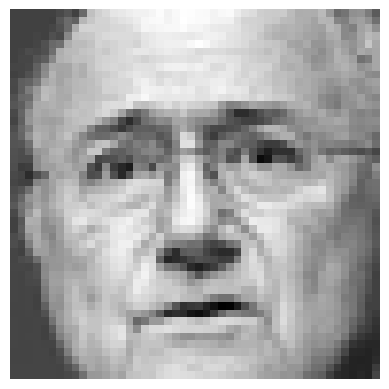

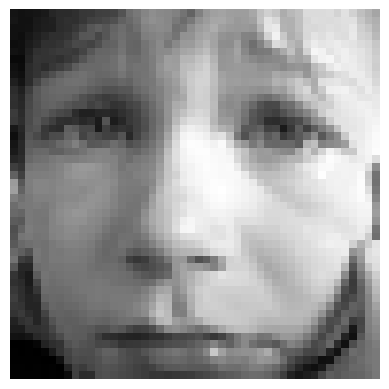

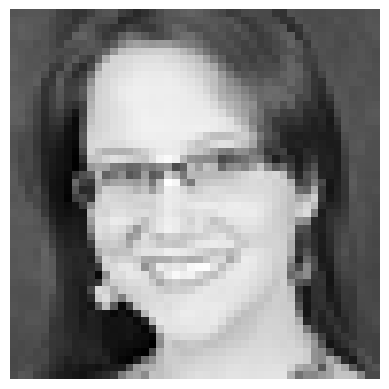

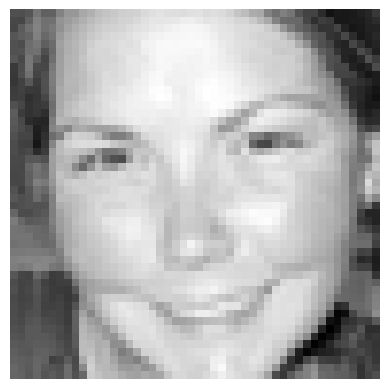

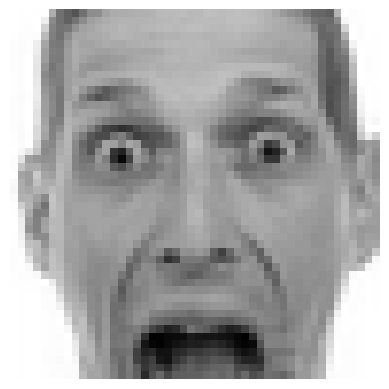

In [57]:
rostos = []
amostras = 0
for pixel_sequence in pixels:
  rosto = [int(pixel) for pixel in pixel_sequence.split(' ')]
  rosto = np.asarray(rosto).reshape((48, 48))
  rostos.append(rosto)
  if (amostras < 10):
    show_image_with_matplotlib(rosto)
  amostras += 1

In [58]:
rostos =  np.asarray(rostos)
rostos.shape

(35887, 48, 48)

In [59]:
# Adicionar uma dimensão para o canal de cores
rostos = np.expand_dims(rostos, -1)
rostos.shape
     

(35887, 48, 48, 1)

In [60]:
#Normalização dos pixels dos rostos
rostos= rostos.astype('float32')
rostos /= 255


In [61]:
emocoes = pd.get_dummies(data['emotion']).values

In [62]:

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [63]:
X_train, X_test, y_train, y_test = train_test_split(rostos, emocoes, test_size=0.1, random_state=42)
_, X_val, _, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [64]:

print('numero de imagens treino', len(X_train))
print('numero de imagens teste', len(X_test))
print('numero de imagens validação', len(X_val))
     

numero de imagens treino 32298
numero de imagens teste 3589
numero de imagens validação 3230


In [65]:
features = 64
classes = 7
epochs = 50
batch_size = 64
largura, altura = 48, 48

model = Sequential()

model.add(Conv2D(features, kernel_size=(3, 3), activation='relu', input_shape=(largura, altura, 1),data_format = 'channels_last' ,kernel_regularizer = l2(0.01)))
model.add(Conv2D(features, kernel_size=(3, 3), activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5)) #dropout ideal seria cerca de 0.2 porém a implementação original utiliza 0.5

model.add(Conv2D(2*features, kernel_size=(3, 3), activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(2*features, kernel_size=(3, 3), activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*features, kernel_size=(3, 3), activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*features, kernel_size=(3, 3), activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*2*features, kernel_size=(3, 3), activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*features, kernel_size=(3, 3), activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
# A cada grupo de camadas, se utiliza o dobro do grupo passado pois as primeiras camadas são para características simples portanto necessitam de poucos filtros
# enquanto as camadas mais profundas detectam caracteristicas mais avançadas e
# sutis
model.add(Flatten())

# Após realizar o flatenning é necessário criar a rede neural densa

model.add(Dense(2*2*2*features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*2*features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*features, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(classes, activation='softmax'))
model.summary()

c:\Users\daneil\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 46, 46, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 46, 46, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 23, 23, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 23, 23, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 23, 23, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 23, 23, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 11, 11, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 11, 11, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 11, 11, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 11, 11, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 5, 5, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 5, 5, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 5, 5, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 5, 5, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,905,863 (22.53 MB)

 Trainable params: 5,902,151 (22.51 MB)

 Non-trainable params: 3,712 (14.50 KB)

In [66]:
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2= 0.999, epsilon = 1e-7),
              metrics=['accuracy'])
arquivo = 'modelo_01_expressoes.keras'
arquivo_json = 'modelo_01_expressoes.json'

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1,)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto') # Caso não apresente melhorias em 8 épocas encerra o processo de treinamento
checkpointer = ModelCheckpoint(filepath=arquivo, verbose=1, save_best_only=True) # Salva o melhor modelo em um arquivo, evitando que o resultado após as épocas seja um modelo subotimizado
     
     

In [67]:
model_json = model.to_json()
with open(arquivo_json, "w") as json_file:
    json_file.write(model_json)
     

In [68]:
hist = model.fit(np.array(X_train), np.array(y_train),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(np.array(X_val), np.array(y_val)), # Expõe qual base de dados será utilizada para validação
          shuffle=True,
          callbacks=[lr_reducer, early_stopper, checkpointer])
     

Epoch 1/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.2021 - loss: 2.2747
Epoch 1: val_loss improved from inf to 1.83382, saving model to modelo_01_expressoes.keras
505/505 ━━━━━━━━━━━━━━━━━━━━ 330s 643ms/step - accuracy: 0.2022 - loss: 2.2741 - val_accuracy: 0.2467 - val_loss: 1.8338 - learning_rate: 0.0010
Epoch 2/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.2409 - loss: 1.8368
Epoch 2: val_loss improved from 1.83382 to 1.80384, saving model to modelo_01_expressoes.keras
505/505 ━━━━━━━━━━━━━━━━━━━━ 317s 627ms/step - accuracy: 0.2409 - loss: 1.8367 - val_accuracy: 0.2480 - val_loss: 1.8038 - learning_rate: 0.0010
Epoch 3/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.2519 - loss: 1.8080
Epoch 3: val_loss improved from 1.80384 to 1.75834, saving model to modelo_01_expressoes.keras
505/505 ━━━━━━━━━━━━━━━━━━━━ 303s 600ms/step - accuracy: 0.2519 - loss: 1.8080 - val_accuracy: 0.2724 - val_loss: 1.7583 - learning_rate: 0.0010
Epoch 4/50
505/505 ━